## AISE4010- Project - Traffic Congestion

### Group 7:
#### Aaron Triguero, Khen Agnes, Shiv Pi Patel



In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

## View raw files for speed, occupancy, travel time

                     Occupancy
timestamp                     
2015-09-01 11:30:00      13.56
2015-09-01 11:35:00       8.33
2015-09-01 11:40:00      11.78
2015-09-01 11:55:00      15.28
2015-09-01 12:00:00      10.06


<Axes: xlabel='timestamp', ylabel='average # cars'>

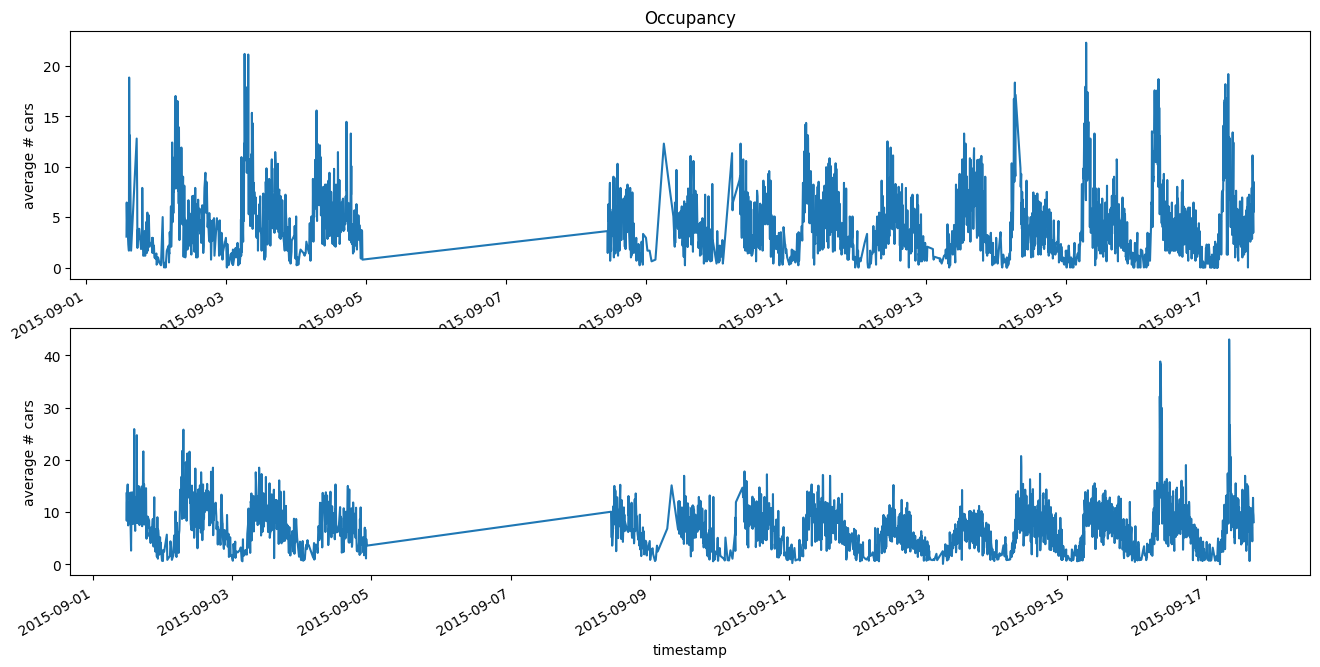

In [43]:
# Load Occupancy dataset
df_o1 = pd.read_csv('occupancy_6005.csv').rename(columns={'value':'Occupancy'})
df_o2 = pd.read_csv('occupancy_t4013.csv').rename(columns={'value':'Occupancy'})

# Set index
df_o1['timestamp'] = pd.to_datetime(df_o1['timestamp'])   # to datetime
df_o2['timestamp'] = pd.to_datetime(df_o2['timestamp'])
df_o1 = df_o1.set_index('timestamp')
df_o2 = df_o2.set_index('timestamp')
print(df_o2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_o1['Occupancy'].plot(ylabel='average # cars',title='Occupancy')
plt.subplot(2, 1, 2)
df_o2['Occupancy'].plot(ylabel='average # cars')

                     Travel Time
timestamp                       
2015-07-28 11:56:00          248
2015-07-28 12:06:00          178
2015-07-28 12:25:00          155
2015-07-28 13:56:00          121
2015-07-28 14:06:00          103


<Axes: xlabel='timestamp', ylabel='seconds'>

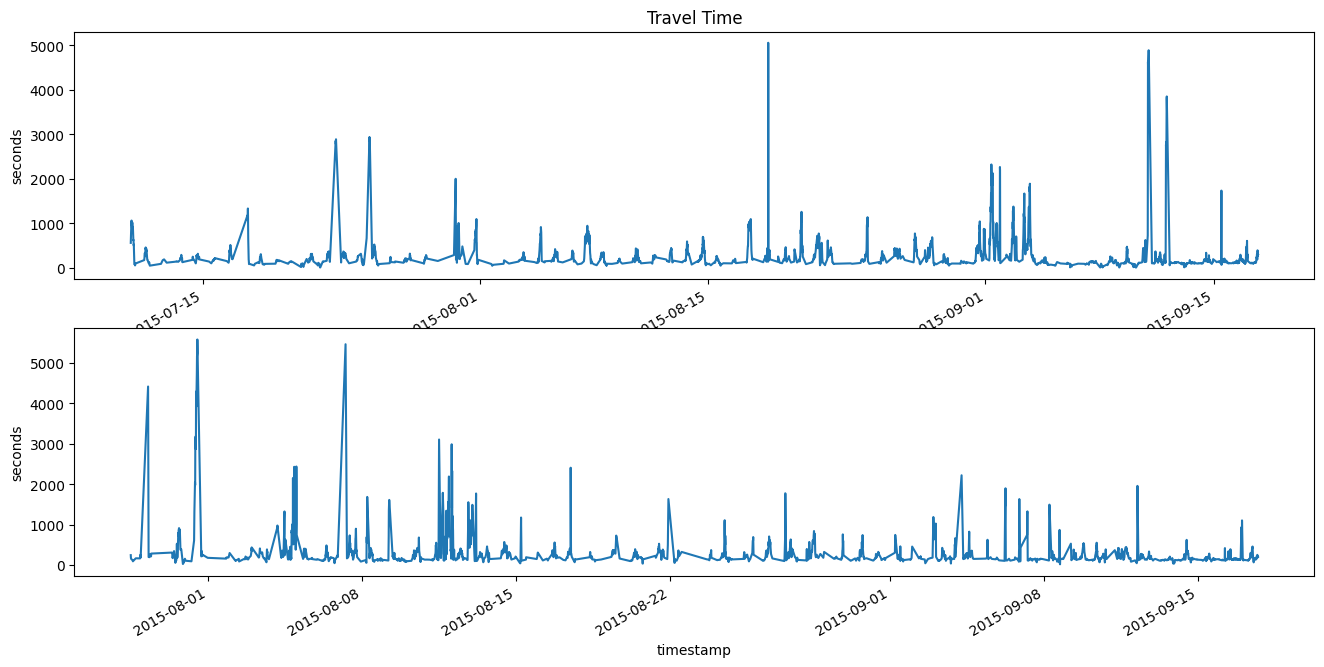

In [44]:
# Load TravelTime dataset
df_t1 = pd.read_csv('TravelTime_387.csv').rename(columns={'value':'Travel Time'})
df_t2 = pd.read_csv('TravelTime_451.csv').rename(columns={'value':'Travel Time'})

# Set index
df_t1['timestamp'] = pd.to_datetime(df_t1['timestamp'])   # to datetime
df_t2['timestamp'] = pd.to_datetime(df_t2['timestamp'])
df_t1 = df_t1.set_index('timestamp')
df_t2 = df_t2.set_index('timestamp')
print(df_t2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
df_t1['Travel Time'].plot(ylabel='seconds',title='Travel Time')
plt.subplot(2, 1, 2)
df_t2['Travel Time'].plot(ylabel='seconds')

                     Speed
timestamp                 
2015-09-01 11:25:00     58
2015-09-01 11:30:00     63
2015-09-01 11:35:00     63
2015-09-01 11:40:00     64
2015-09-01 11:55:00     58


<Axes: xlabel='timestamp', ylabel='km/h'>

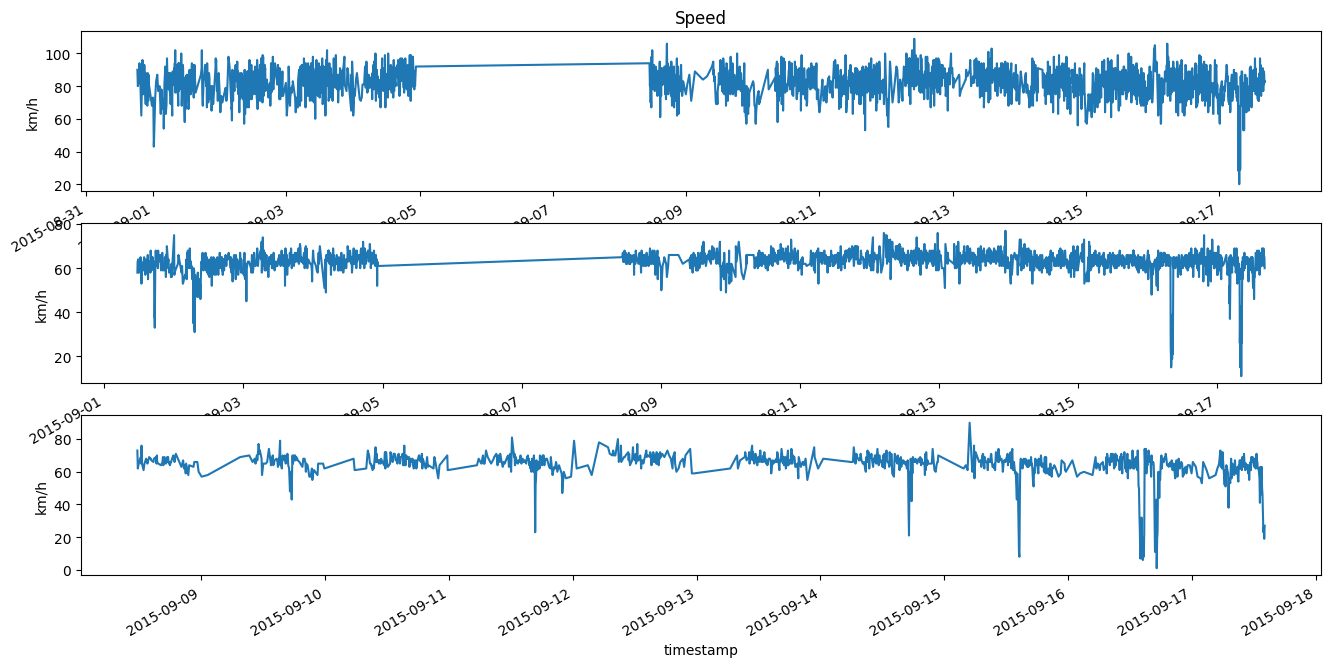

In [45]:
# Load speed dataset
df_s1 = pd.read_csv('speed_6005.csv').rename(columns={'value':'Speed'})
df_s2 = pd.read_csv('speed_t4013.csv').rename(columns={'value':'Speed'})
df_s3 = pd.read_csv('speed_7578.csv').rename(columns={'value':'Speed'})

# Set index
df_s1['timestamp'] = pd.to_datetime(df_s1['timestamp'])   # to datetime
df_s2['timestamp'] = pd.to_datetime(df_s2['timestamp'])
df_s3['timestamp'] = pd.to_datetime(df_s3['timestamp'])
df_s1 = df_s1.set_index('timestamp')
df_s2 = df_s2.set_index('timestamp')
df_s3 = df_s3.set_index('timestamp')
print(df_s2.head())

# plot
plt.figure(figsize=(16,8))
plt.subplot(3, 1, 1)
df_s1['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 2)
df_s2['Speed'].plot(ylabel='km/h')
plt.subplot(3, 1, 3)
df_s3['Speed'].plot(ylabel='km/h')

## 1. Form Dataset and Preprocess

- notice preprocess choices made, such as resampling

#### Joining, Resampling and Normalizing

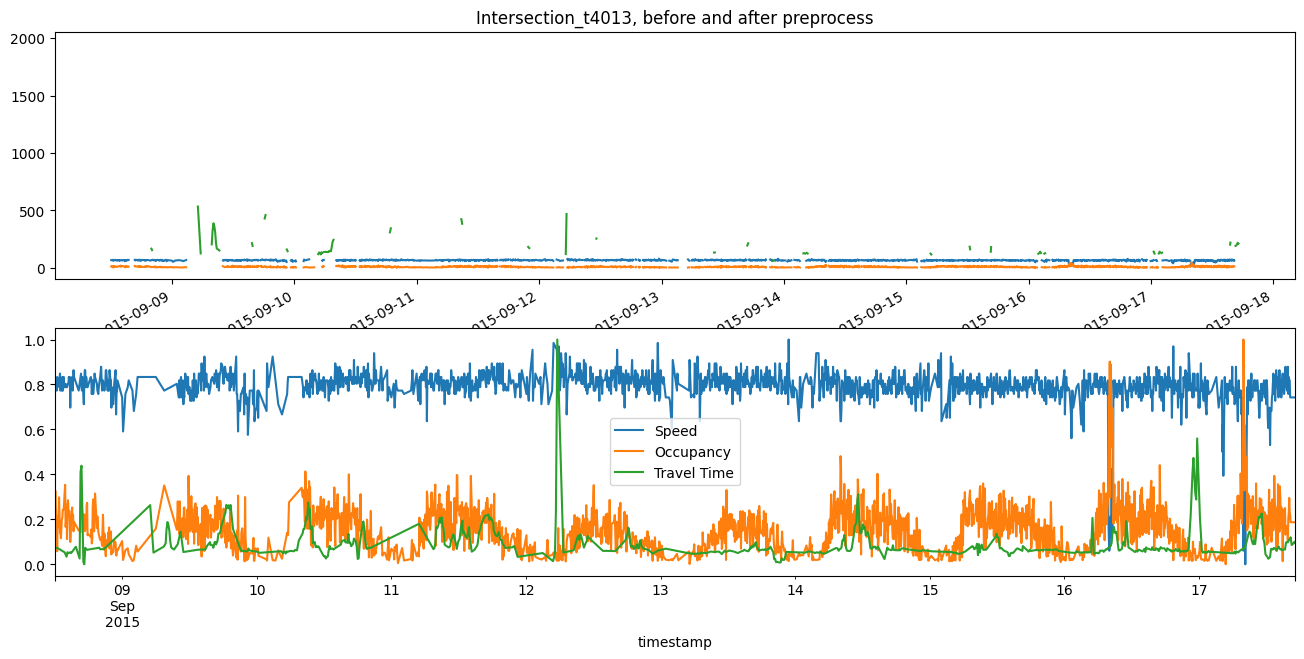

In [46]:
# Dataset for intersection 6005
# data_6005 = df_o1.join(df_t1, how='outer').join(df_s1, how='outer')
# data_6005 = data_6005['2015-09-09':]  # take only data after certain date             # if we wanted to do 2 intersections

# Dataset for intersection t4013
data_t4013 = df_o2.join(df_t2, how='outer').join(df_s2, how='outer')
data = data_t4013['2015-09-08 12':]  # take only data after certain date



# Plot data before resampling
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
data['Speed'].plot(title='Intersection_t4013, before and after preprocess')#, ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()


# Data after resampling (using mean) to 5 min intervals
# and handling missing data using _______(interpolation)________
data = data.resample('5min').mean()
data = data.interpolate()

data['Travel Time'] = data['Travel Time'].bfill()   # special case where Travel Time has few initial data points missing

# Normalize each variable using ________(MinMax)_________
scaler = MinMaxScaler()
data['Speed'] = scaler.fit_transform(data[['Speed']])
data['Occupancy'] = scaler.fit_transform(data[['Occupancy']])
data['Travel Time'] = scaler.fit_transform(data[['Travel Time']])


# Plot data after preprocessing
plt.subplot(2,1,2)
data['Speed'].plot()#ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()
plt.legend()
plt.show()


In [47]:
data.shape    # (2510 timesteps, 3 variables)

(2654, 3)

#### Components of the time series

In [48]:
# check seasonality, trends, etc for each variable

#### Splitting train and test sets

In [49]:
# Sliding window to split data

def sliding_window(data, n):
    # data: original data
    # n: window size
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data[i:(i + n)])
        y.append(data[i + n])
    return np.array(X), np.array(y)


# For n timesteps
n_steps = 12      # each 60 minutes (5 minutes per timestep)

# Each variable
Xo, yo = sliding_window(data['Occupancy'], n_steps)
Xs, ys = sliding_window(data['Speed'], n_steps)
Xt, yt = sliding_window(data['Travel Time'], n_steps)

# Split data into training testing sets
split = int(len(Xo)*0.8)

Xo_train, Xo_test = Xo[:split], Xo[split:]
yo_train, yo_test = yo[:split], yo[split:]

Xs_train, Xs_test = Xs[:split], Xs[split:]
ys_train, ys_test = ys[:split], ys[split:]

Xt_train, Xt_test = Xt[:split], Xt[split:]
yt_train, yt_test = yt[:split], yt[split:]

# Reshape
Xo_train = Xo_train.reshape(Xo_train.shape[0], Xo_train.shape[1], 1)
Xo_test = Xo_test.reshape(Xo_test.shape[0], Xo_test.shape[1], 1)

Xs_train = Xs_train.reshape(Xs_train.shape[0], Xs_train.shape[1], 1)
Xs_test = Xs_test.reshape(Xs_test.shape[0], Xs_test.shape[1], 1)

Xt_train = Xt_train.reshape(Xt_train.shape[0], Xt_train.shape[1], 1)
Xt_test = Xt_test.reshape(Xt_test.shape[0], Xt_test.shape[1], 1)


/tmp/ipykernel_3619/4273797092.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + n])


## 2. Models, Training

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model

from sklearn.metrics import mean_squared_error, mean_absolute_error

from time import time

### CNN Model

In [58]:
# CNN model
model_CNN = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer ________ and loss _________
model_CNN.compile(optimizer='adam', loss='mean_squared_error')    # why?

model_CNN_s, model_CNN_o, model_CNN_t = model_CNN, model_CNN, model_CNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 32
VAL_SPLIT = 0.2



#### Training using CNN models

Epoch 1/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0692 - val_loss: 0.0028
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0201 - val_loss: 0.0021
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0031
Epoch 4/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0025
Epoch 5/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0025
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0021
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0023
Epoch 8/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0021
Epoch 9/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0019
Epoch 10/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0023
Epoch 11/50
53/53 

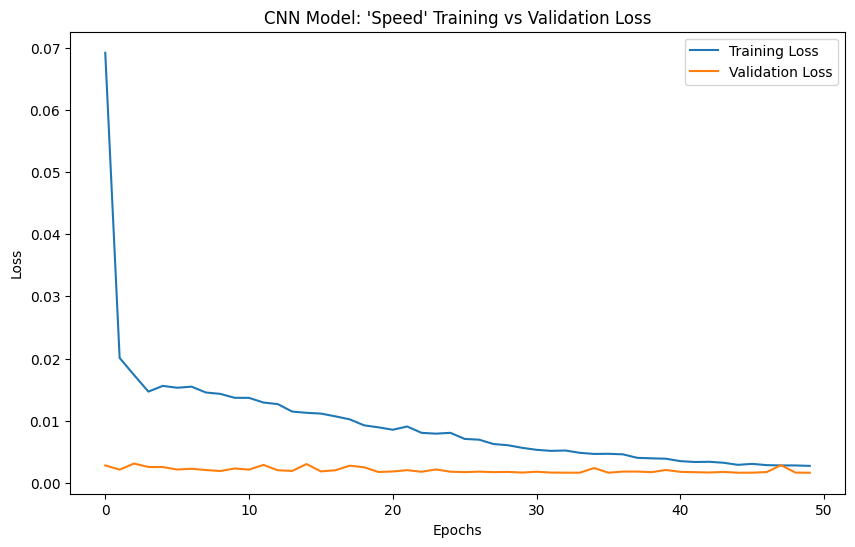

CNN Training Time for 'Speed': 17.612 seconds


In [59]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")


Epoch 1/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0467 - val_loss: 0.0051
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0049
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 4/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 5/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 7/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 8/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 9/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 10/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 11/50
53/53 [

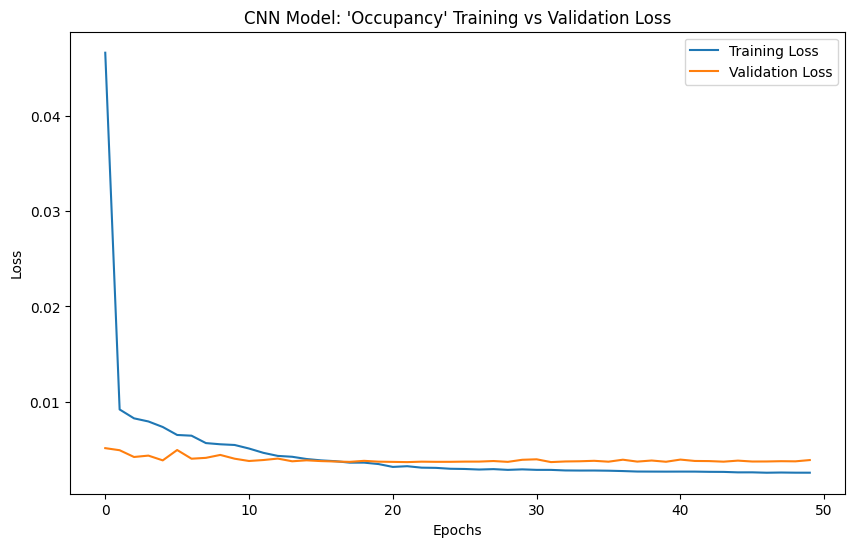

CNN Training Time for 'Occupancy': 17.365 seconds


In [60]:
# Occupancy data
start_time = time()
cnn_history_occupancy = model_CNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(cnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Occupancy\': {cnn_time_occupancy:.3f} seconds")

Epoch 1/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 1.4349e-04
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 8.0805e-04 - val_loss: 1.0764e-04
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: 6.0702e-04 - val_loss: 1.2847e-04
Epoch 4/50
53/53 [==============================] - 0s 7ms/step - loss: 6.4796e-04 - val_loss: 7.0945e-05
Epoch 5/50
53/53 [==============================] - 0s 6ms/step - loss: 4.6937e-04 - val_loss: 6.1828e-05
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 5.5360e-04 - val_loss: 8.0568e-05
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 5.0493e-04 - val_loss: 8.1413e-05
Epoch 8/50
53/53 [==============================] - 0s 6ms/step - loss: 4.7297e-04 - val_loss: 9.8385e-05
Epoch 9/50
53/53 [==============================] - 0s 6ms/step - loss: 4.6694e-04 - val_loss: 6.7578e-05
Epoch 10/50
53/53 [==============================]

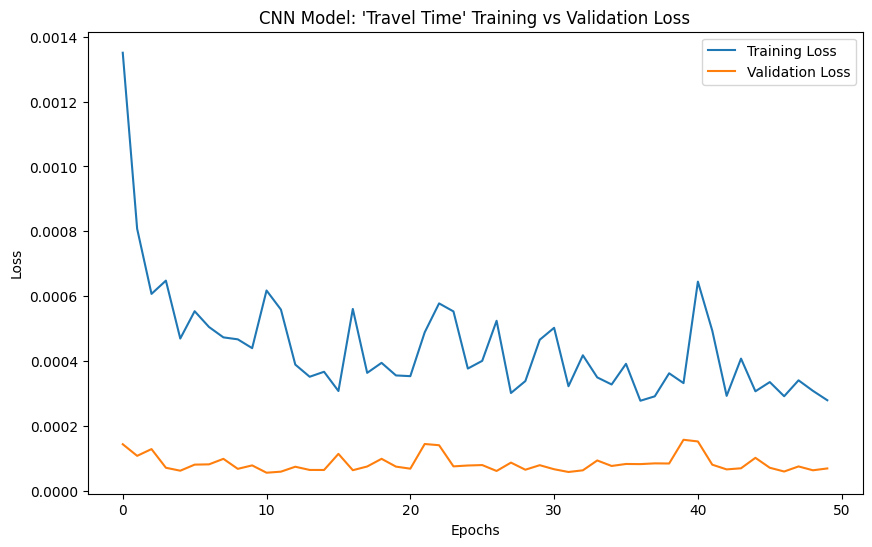

CNN Training Time for 'Travel Time': 17.680 seconds


In [61]:
# Travel Time data
start_time = time()
cnn_history_ttime = model_CNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(cnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Travel Time\': {cnn_time_ttime:.3f} seconds")


Epoch 1/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0019
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0020
Epoch 3/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0017
Epoch 4/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 5/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 6/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 8/50
53/53 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 9/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 10/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 11/50
53/53 [

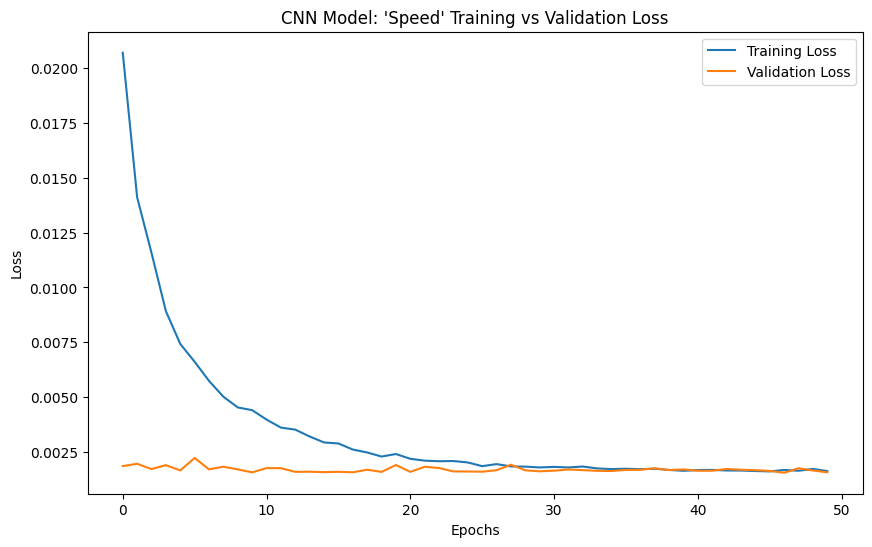

CNN Training Time for 'Speed': 15.751 seconds


In [62]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")

17/17 [==============================] - 0s 1ms/step
CNN Test: 'Speed' RMSE: 0.10548595072862017
CNN Test: 'Speed' MAE: 0.05317189322227689


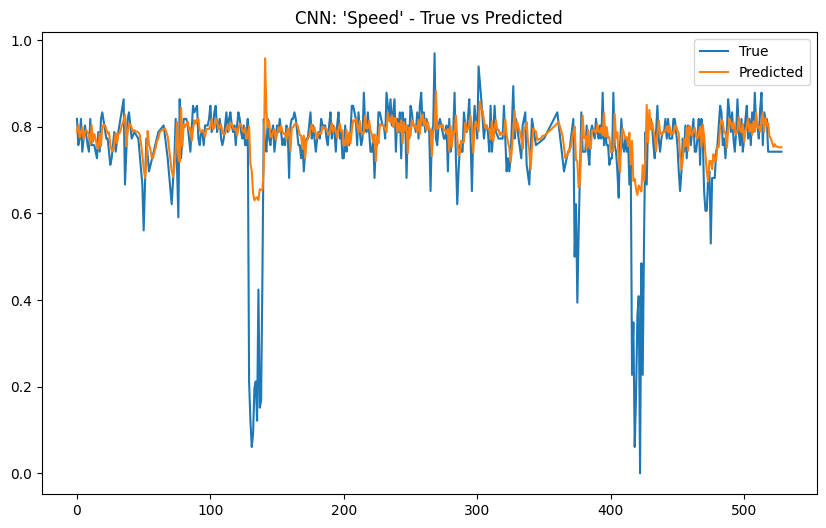

In [63]:
# Evaluate and plot predictions
ys_pred_cnn = model_CNN_s.predict(Xs_test)
# Calculate RMSE and MAE
cnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_cnn))
cnn_mae_s = mean_absolute_error(ys_test, ys_pred_cnn)           # why mse and rmse?

print(f'CNN Test: \'Speed\' RMSE: {cnn_rmse_s}')
print(f'CNN Test: \'Speed\' MAE: {cnn_mae_s}')

plt.figure(figsize=(10,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_cnn, label='Predicted')
plt.title('CNN: \'Speed\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 1ms/step
CNN Test: 'Occupancy' RMSE: 0.4953034655365436
CNN Test: 'Occupancy' MAE: 0.48431805672082334


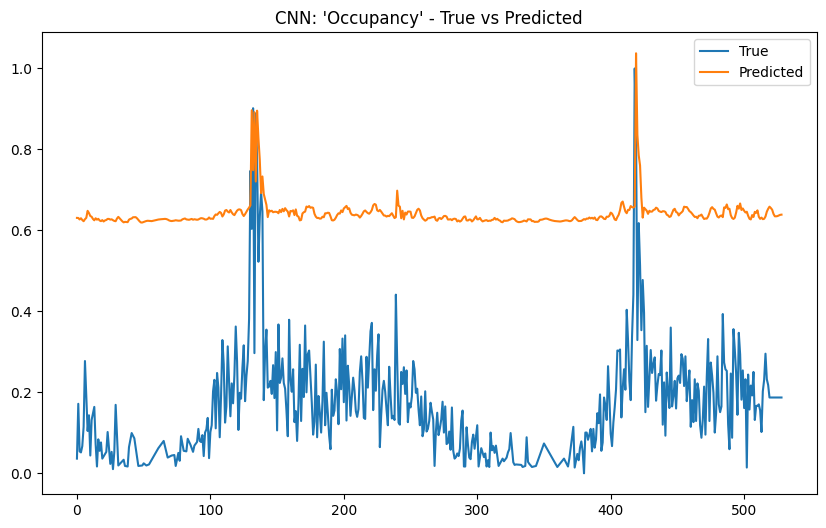

In [64]:
# Evaluate and plot predictions
yo_pred_cnn = model_CNN_o.predict(Xo_test)
# Calculate RMSE and MAE
cnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_cnn))
cnn_mae_o = mean_absolute_error(yo_test, yo_pred_cnn)

print(f'CNN Test: \'Occupancy\' RMSE: {cnn_rmse_o}')
print(f'CNN Test: \'Occupancy\' MAE: {cnn_mae_o}')

plt.figure(figsize=(10,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_cnn, label='Predicted')
plt.title('CNN: \'Occupancy\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 2ms/step
CNN Test: 'Travel Time' RMSE: 0.5476900826111231
CNN Test: 'Travel Time' MAE: 0.5444434786062176


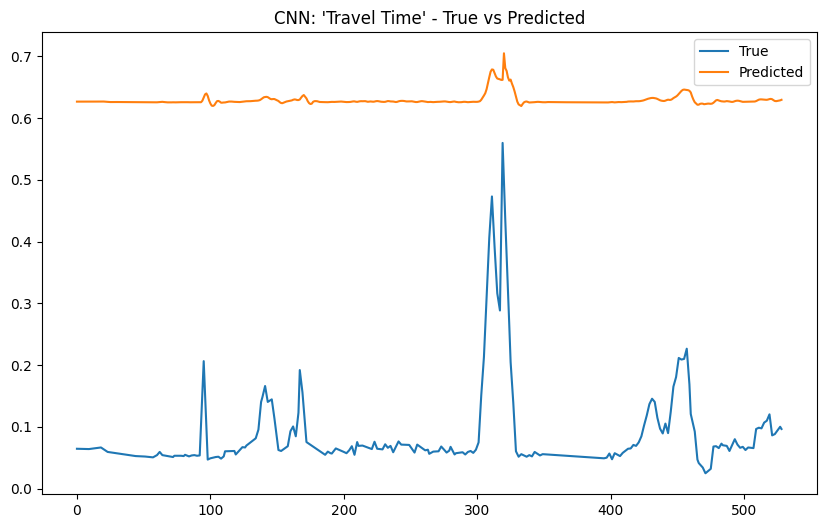

In [65]:
# Evaluate and plot predictions
yt_pred_cnn = model_CNN_t.predict(Xt_test)
# Calculate RMSE and MAE
cnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_cnn))
cnn_mae_t = mean_absolute_error(yt_test, yt_pred_cnn)

print(f'CNN Test: \'Travel Time\' RMSE: {cnn_rmse_t}')
print(f'CNN Test: \'Travel Time\' MAE: {cnn_mae_t}')

plt.figure(figsize=(10,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_cnn, label='Predicted')
plt.title('CNN: \'Travel Time\' - True vs Predicted')
plt.legend()
plt.show()

## RNN Models


In [66]:
# RNN model
model_RNN = Sequential([
    SimpleRNN(40, activation='relu', input_shape=(Xo_train.shape[1], 1)),   # why layer size 40?
    Dense(1)
])

# Optimizer ________ and loss _________
model_RNN.compile(optimizer='adam', loss='mean_squared_error')    # why?

model_RNN_s, model_RNN_o, model_RNN_t = model_RNN, model_RNN, model_RNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 16
VAL_SPLIT = 0.2


#### Training using RNN models

Epoch 1/50
106/106 [==============================] - 3s 20ms/step - loss: 0.1134 - val_loss: 0.0019
Epoch 2/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
106/106 [==============================] - 3s 30ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/50
106/106 [==============================] - 2s 17ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
106/106 [==============================] - 2s 17ms/step - loss: 0.0019 - val_lo

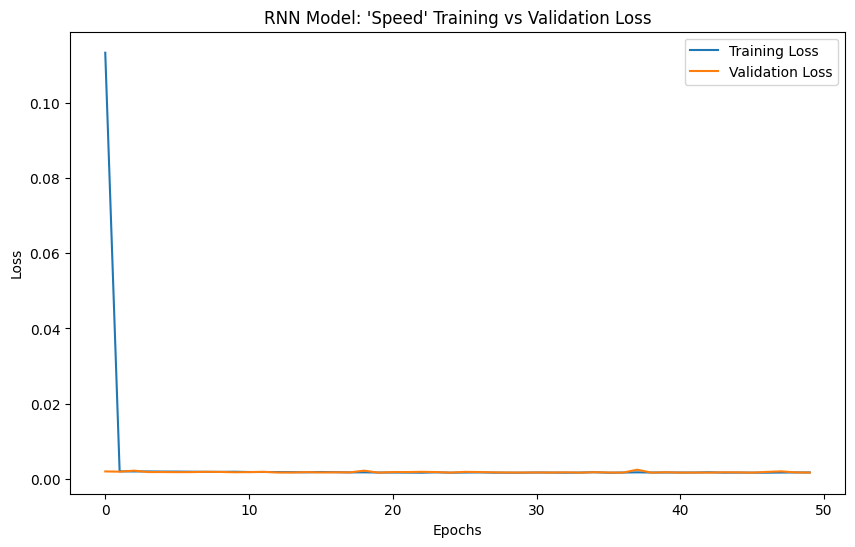

RNN Training Time for 'Speed': 105.524 seconds


In [67]:
# Speed data
start_time = time()
rnn_history_speed = model_RNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_speed.history['loss'], label='Training Loss')
plt.plot(rnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Speed\': {rnn_time_speed:.3f} seconds")


Epoch 1/50
106/106 [==============================] - 2s 21ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 2/50
106/106 [==============================] - 3s 30ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 4/50
106/106 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 5/50
106/106 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 6/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 7/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 8/50
106/106 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 9/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 10/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0025 - val_lo

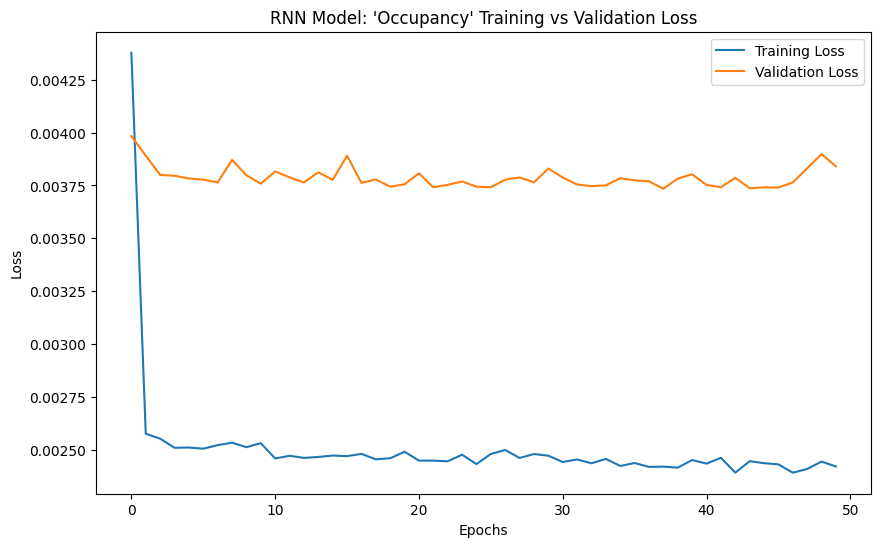

RNN Training Time for 'Occupancy': 108.585 seconds


In [68]:
# Occupancy data
start_time = time()
rnn_history_occupancy = model_RNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(rnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Occupancy\': {rnn_time_occupancy:.3f} seconds")

Epoch 1/50
106/106 [==============================] - 2s 21ms/step - loss: 8.0305e-04 - val_loss: 8.9102e-05
Epoch 2/50
106/106 [==============================] - 2s 20ms/step - loss: 3.8345e-04 - val_loss: 7.9986e-05
Epoch 3/50
106/106 [==============================] - 2s 21ms/step - loss: 2.6246e-04 - val_loss: 5.9814e-05
Epoch 4/50
106/106 [==============================] - 2s 20ms/step - loss: 2.3682e-04 - val_loss: 5.5784e-05
Epoch 5/50
106/106 [==============================] - 2s 21ms/step - loss: 2.2623e-04 - val_loss: 5.5163e-05
Epoch 6/50
106/106 [==============================] - 2s 20ms/step - loss: 2.0191e-04 - val_loss: 7.3441e-05
Epoch 7/50
106/106 [==============================] - 2s 20ms/step - loss: 2.0230e-04 - val_loss: 6.5312e-05
Epoch 8/50
106/106 [==============================] - 2s 21ms/step - loss: 2.0031e-04 - val_loss: 6.4053e-05
Epoch 9/50
106/106 [==============================] - 2s 21ms/step - loss: 1.8448e-04 - val_loss: 5.7497e-05
Epoch 10/50
106/106

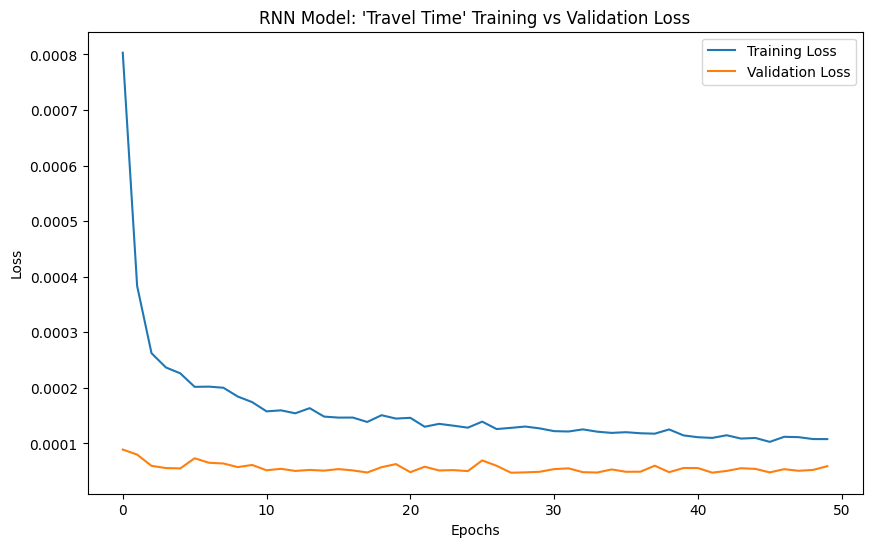

RNN Training Time for 'Travel Time': 106.309 seconds


In [69]:
# Travel Time data
start_time = time()
rnn_history_ttime = model_RNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)
rnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(rnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(rnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Travel Time\': {rnn_time_ttime:.3f} seconds")


### Evaluating using RNN Models

17/17 [==============================] - 0s 5ms/step
RNN Test: 'Speed' RMSE: 0.12369227280513957
RNN Test: 'Speed' MAE: 0.07830644478163208


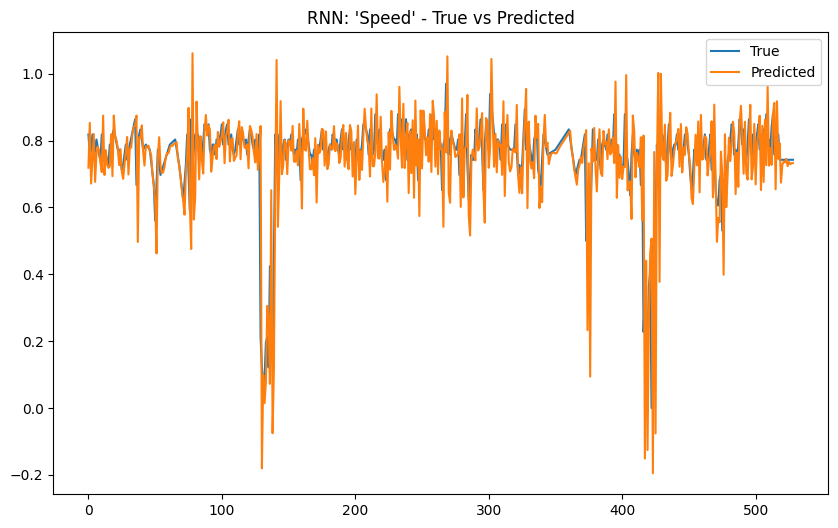

In [70]:
# Evaluate and plot predictions
ys_pred_rnn = model_RNN_s.predict(Xs_test)
# Calculate RMSE and MAE
rnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_rnn))
rnn_mae_s = mean_absolute_error(ys_test, ys_pred_rnn)           # why mse and rmse?

print(f'RNN Test: \'Speed\' RMSE: {rnn_rmse_s}')
print(f'RNN Test: \'Speed\' MAE: {rnn_mae_s}')

plt.figure(figsize=(10,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_rnn, label='Predicted')
plt.title('RNN: \'Speed\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 4ms/step
RNN Test: 'Occupancy' RMSE: 0.15340973552672493
RNN Test: 'Occupancy' MAE: 0.09751491364442152


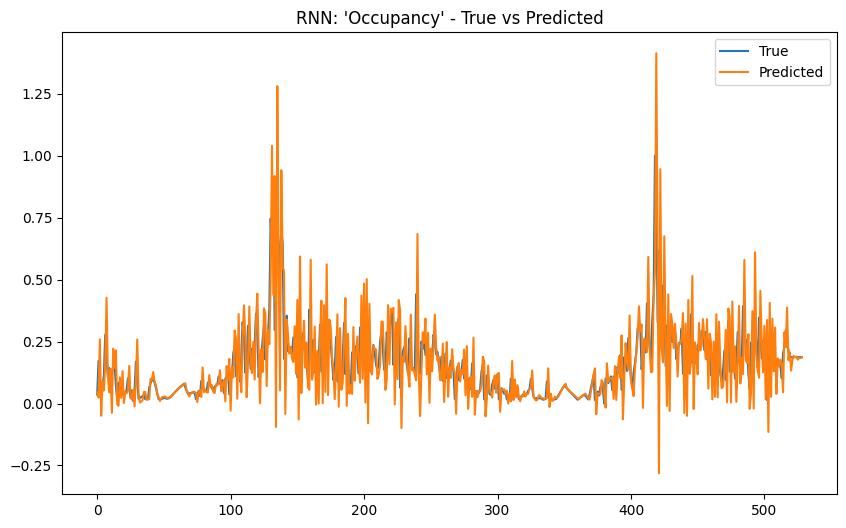

In [71]:
# Evaluate and plot predictions
yo_pred_rnn = model_RNN_o.predict(Xo_test)
# Calculate RMSE and MAE
rnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_rnn))
rnn_mae_o = mean_absolute_error(yo_test, yo_pred_rnn)

print(f'RNN Test: \'Occupancy\' RMSE: {rnn_rmse_o}')
print(f'RNN Test: \'Occupancy\' MAE: {rnn_mae_o}')

plt.figure(figsize=(10,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_rnn, label='Predicted')
plt.title('RNN: \'Occupancy\' - True vs Predicted')
plt.legend()
plt.show()

17/17 [==============================] - 0s 4ms/step
RNN Test: 'Travel Time' RMSE: 0.013876737243200788
RNN Test: 'Travel Time' MAE: 0.005610475783189273


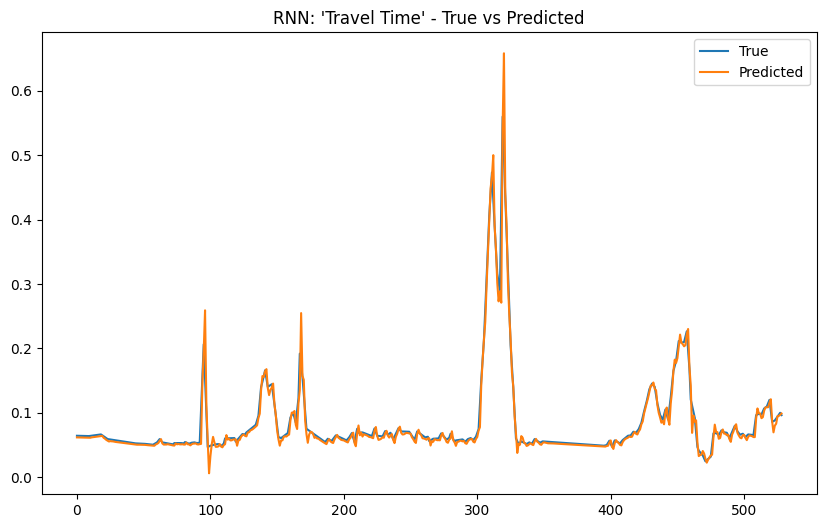

In [72]:
# Evaluate and plot predictions
yt_pred_rnn = model_RNN_t.predict(Xt_test)
# Calculate RMSE and MAE
rnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_rnn))
rnn_mae_t = mean_absolute_error(yt_test, yt_pred_rnn)

print(f'RNN Test: \'Travel Time\' RMSE: {rnn_rmse_t}')
print(f'RNN Test: \'Travel Time\' MAE: {rnn_mae_t}')

plt.figure(figsize=(10,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_rnn, label='Predicted')
plt.title('RNN: \'Travel Time\' - True vs Predicted')
plt.legend()
plt.show()